# Outbrain Click Prediction
Link: https://www.kaggle.com/c/outbrain-click-prediction

# Team Name:USCGreenHands

## Members:  
#### Xinjie Sun 5562210941
#### Yiqun Gan 9603439162
#### Zelong Chen 3728351730

### ISE 529 Section:Friday

### Score and Ranking:
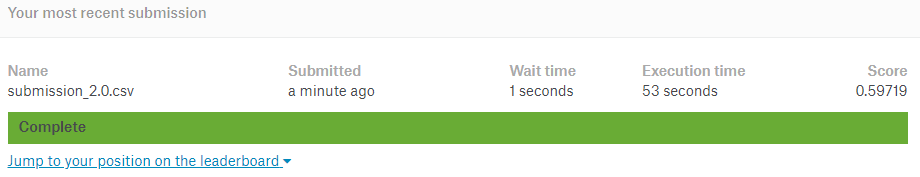

## Data Selections
- Data files that we are using for analysis and prediction
  - clicks_train.csv (Using the first 5,000,000 for data analysis then using the rest for model training and prediction)
    - display_id
    - ad_id
    - clicked (1 if clicked, 0 otherwise)
  - clicks_test.csv
    - display_id
    - ad_id
  - events.csv
    - display_id
    - uuid
    - document_id
    - timestamp
    - platform
    - geo_location
  - promoted_content.csv
    - ad_id
    - document_id
    - campaign_id
    - advertiser_id

### Libraries

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import os
import gc
import seaborn as sns
%matplotlib inline
# visualization
import matplotlib.pyplot as plt

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## Load Files
### clicks_train.csv

In [2]:
# Subset = 0 : All rows of clicks_train
# Subset = 1 : First 5,000,000
subset = 1

if subset == 1:
    # Select First 5,000,000 Rows of clicks_train as File too large
    reader = pd.read_csv('clicks_train.csv',iterator=True,chunksize=5000000)
    train = next(reader)
else:
    # Select All Rows of clicks_train 
    train = pd.read_csv('clicks_train.csv')

### events.csv

In [3]:
# Subset = 0 : All rows of events
# Subset = 1 : First 5,000,000
subset=0
if subset == 1:
    # Select First 5,000,000 Rows of events.csv as File too large
    reader = pd.read_csv('events.csv',iterator=True,chunksize=5000000)
    events = next(reader)
else:
    # Select All Rows of clicks_train 
    events = pd.read_csv('events.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
events.head()

,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505
3,4,85281d0a49f7ac,1777797,234,2,US>WV>564
4,5,8d0daef4bf5b56,252458,338,2,SG>00


In [5]:
userID_counts = events.groupby('uuid')['uuid'].count().sort_values()
print(userID_counts.head())
for i in [2, 5, 10]:
    print('Users that appear less than {} times: {}%'.format(i, round((userID_counts < i).mean() * 100, 2)))

uuid
1000003a6ad6e3    1
ab102e68b2433d    1
ab102fe3632a43    1
ab102fff7d95ff    1
ab10304759d24e    1
Name: uuid, dtype: int64
Users that appear less than 2 times: 88.42%
Users that appear less than 5 times: 99.51%
Users that appear less than 10 times: 99.96%


In [6]:
# As users that appear less than 2 times are more than 92.98%, we can delete users('uuid') column.

### promoted_content.csv

In [7]:
# Load promoted_content.csv
content = pd.read_csv('promoted_content.csv')
# Remove document_id as events.csv already contain this information
content = content.drop('document_id',axis=1) # to be explained as follows

### document.csv

In [8]:
documents_meta = pd.read_csv('documents_meta.csv')
documents_topics = pd.read_csv('documents_topics.csv')
documents_categories = pd.read_csv('documents_categories.csv')
documents_entities = pd.read_csv('documents_entities.csv')

In [10]:
data = pd.merge(train,events,how='left',on='display_id')
data = pd.merge(data,documents_meta,how='left',on='document_id')
data = pd.merge(data,documents_entities,how='left',on='document_id')
data = pd.merge(data,documents_topics,how='left',on='document_id')
data = pd.merge(data,documents_categories,how='left',on='document_id')
# Read in Test file
test= pd.read_csv('clicks_test.csv')
data1 = pd.merge(test,events,how='left',on='display_id')
data1 = pd.merge(data1,documents_meta,how='left',on='document_id')
data1 = pd.merge(data1,documents_entities,how='left',on='document_id')
data1 = pd.merge(data1,documents_topics,how='left',on='document_id')
data1 = pd.merge(data1,documents_categories,how='left',on='document_id')

In [11]:
Source_id_NaN_numbers=int(data['source_id'].isna().sum())
Source_id_NaN_rate=int(data['source_id'].isna().sum())/len(data)
Publisher_id_NaN_numbers=int(data['publisher_id'].isna().sum())
Publisher_id_NaN_rate=int(data['publisher_id'].isna().sum())/len(data)
Publish_time_NaN_numbers=int(data['publish_time'].isna().sum())
Publish_time_NaN_rate=int(data['publish_time'].isna().sum())/len(data)
Entity_id_NaN_numbers=int(data['entity_id'].isna().sum())
Entity_id_NaN_rate=int(data['entity_id'].isna().sum())/len(data)
Topic_id_NaN_numbers=int(data['topic_id'].isna().sum())
Topic_id_NaN_rate=int(data['topic_id'].isna().sum())/len(data)
Category_id_NaN_numbers=int(data['category_id'].isna().sum())
Category_id_NaN_rate=int(data['category_id'].isna().sum())/len(data)

In [16]:
Source_id_NaN_numbers1=int(data1['source_id'].isna().sum())
Source_id_NaN_rate1=int(data1['source_id'].isna().sum())/len(data1)
Publisher_id_NaN_numbers1=int(data1['publisher_id'].isna().sum())
Publisher_id_NaN_rate1=int(data1['publisher_id'].isna().sum())/len(data1)
Publish_time_NaN_numbers1=int(data1['publish_time'].isna().sum())
Publish_time_NaN_rate1=int(data1['publish_time'].isna().sum())/len(data1)
Entity_id_NaN_numbers1=int(data1['entity_id'].isna().sum())
Entity_id_NaN_rate1=int(data1['entity_id'].isna().sum())/len(data1)
Topic_id_NaN_numbers1=int(data1['topic_id'].isna().sum())
Topic_id_NaN_rate1=int(data1['topic_id'].isna().sum())/len(data1)
Category_id_NaN_numbers1=int(data1['category_id'].isna().sum())
Category_id_NaN_rate1=int(data1['category_id'].isna().sum())/len(data1)

In [14]:
NaN_matrix = pd.DataFrame({
    'Feature': ['Source_id', 'Publisher_id', 'Entity_id', 'Topic_id', 'Category_id'],
    'NaN_numbers_train': [Source_id_NaN_numbers, Publisher_id_NaN_numbers,
                    Entity_id_NaN_numbers, Topic_id_NaN_numbers, Category_id_NaN_numbers],
    'NaN_rate_train': [Source_id_NaN_rate, Publisher_id_NaN_rate, 
                 Entity_id_NaN_rate, Topic_id_NaN_rate, Category_id_NaN_rate],
    'NaN_numbers_test': [Source_id_NaN_numbers1, Publisher_id_NaN_numbers1,
                    Entity_id_NaN_numbers1, Topic_id_NaN_numbers1, Category_id_NaN_numbers1],
    'NaN_rate_test': [Source_id_NaN_rate1, Publisher_id_NaN_rate1, 
                 Entity_id_NaN_rate1, Topic_id_NaN_rate1, Category_id_NaN_rate1],
    })
NaN_matrix

,Feature,NaN_numbers_train,NaN_rate_train,NaN_numbers_test,NaN_rate_test
0,Source_id,90,5.558802e-07,35448,0.000426
1,Publisher_id,102,6.299975e-07,35448,0.000426
2,Entity_id,7522714,4.646364e-02,12160182,0.146103
3,Topic_id,175951,1.086752e-03,8250899,0.036668
4,Category_id,443170,2.737216e-03,1913285,0.008503


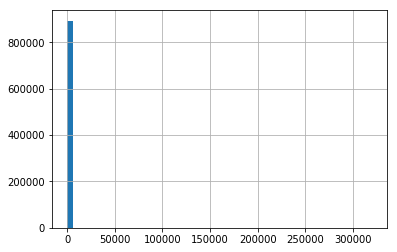

Documents that appear less than 2 times: 35.72%
Documents that appear less than 5 times: 64.52%
Documents that appear less than 10 times: 77.81%
Documents that appear less than 50 times: 93.44%
Documents that appear less than 200 times: 98.16%
Documents that appear less than 500 times: 99.32%
Documents that appear less than 1000 times: 99.7%


In [15]:
document_unique_count = events['document_id'].value_counts()
document_unique_count.hist(bins=50)
plt.show()

for i in [2,5,10,50,200,500,1000]:
    print('Documents that appear less than {} times: {}%'.format(i, round((document_unique_count < i).mean() * 100, 2)))

try:del document_unique_count 
except:pass;gc.collect()


In [ ]:
# Due to large number of NA values and most documents appear less than 10 times, we now ignore the document data
#the total dataset is about 36 GB, our computer will run out of memory without reducing these data.

## Join files into a single dataframe

In [5]:
# Merge train data + content on ad_id to get features about the ad
data = pd.merge(train,content,how='left',on='ad_id')
data.head()

# Merge train data + events on ad_id to get features about the ad 
data = pd.merge(data,events,how='left',on='display_id')
# Drop uuid (user id) as it is not a relevant feature
data = data.drop('uuid',axis=1)
data.head()

,display_id,ad_id,clicked,campaign_id,advertiser_id,document_id,timestamp,platform,geo_location
0,1,42337,0,5969,1499,379743,61,3,US>SC>519
1,1,139684,0,17527,2563,379743,61,3,US>SC>519
2,1,144739,1,18488,2909,379743,61,3,US>SC>519
3,1,156824,0,7283,1919,379743,61,3,US>SC>519
4,1,279295,0,27524,1820,379743,61,3,US>SC>519


## Data Cleaning
### NaN Values

In [6]:
# Number of NaN values in data
data.isna().sum()

display_id         0
ad_id              0
clicked            0
campaign_id        0
advertiser_id      0
document_id        0
timestamp          0
platform           0
geo_location     113
dtype: int64

### geo_location

In [7]:
# Fill NaN values with string to represent Not in_US 
data.geo_location = data.geo_location.fillna('CA')

In [8]:
data.geo_location.value_counts()[:10]

US>CA>803    205094
US>NY>501    184027
US           142234
US>CA>807    141779
CA>ON        119309
US>IL>602    119245
US>TX>618    109436
US>TX>623     93014
US>PA>504     89206
US>MI>505     86138
Name: geo_location, dtype: int64

In [9]:
# Split into categorical feature of in_US
# 0 for not in US and 1 for in US
arr = []
for i in data.geo_location:
    if i.find("US") == -1:
        # Not in US
        arr.append(0)
    else:
        # In US
        arr.append(1)
data['in_US'] = arr
data = data.drop('geo_location',axis=1)

In [10]:
data['in_US'].value_counts()

1    3930758
0    1069242
Name: in_US, dtype: int64

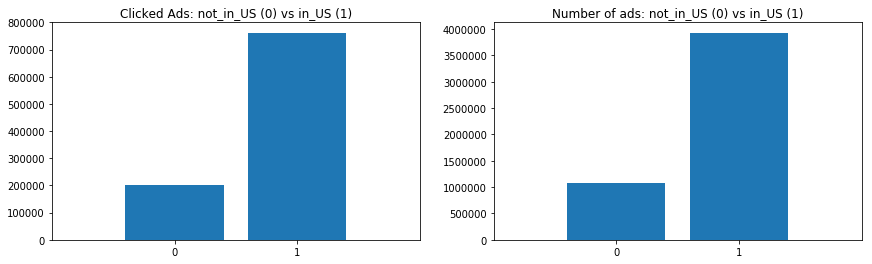

In [11]:
# number of clicks not in US vs in US 
fig, (ax1, ax2) = plt.subplots(1,2) 
fig.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=None, hspace=None)
ax1.bar(range(2), np.bincount(data.in_US[data.clicked==1]), width=0.8, align='center')
ax1.set_title('Clicked Ads: not_in_US (0) vs in_US (1)')
ax1.set(xticks=range(2), xlim=[-1, 2]);

# Number of Ads not in US vs in US
ax2.bar(range(2), np.bincount(data.in_US), width=0.8, align='center')
ax2.set_title('Number of ads: not_in_US (0) vs in_US (1)')
ax2.set(xticks=range(2), xlim=[-1, 2]);

## Categorical Features

In [12]:
data.head()

,display_id,ad_id,clicked,campaign_id,advertiser_id,document_id,timestamp,platform,in_US
0,1,42337,0,5969,1499,379743,61,3,1
1,1,139684,0,17527,2563,379743,61,3,1
2,1,144739,1,18488,2909,379743,61,3,1
3,1,156824,0,7283,1919,379743,61,3,1
4,1,279295,0,27524,1820,379743,61,3,1


### timestamp

In [13]:
# Convert time into year month date time format
data.timestamp = data.timestamp+1465876799998
data.timestamp = pd.to_datetime(data.timestamp,unit='ms')

In [14]:
data.timestamp.min()

Timestamp('2016-06-14 04:00:00.059000')

In [15]:
data.timestamp.max()

Timestamp('2016-06-14 20:35:59.837000')

In [16]:
# Convert Timestamp into categorical feature of Time_of_day
# 1 = morning, 2 = Mid-day, 3 = Evening
arr = []
for i in data.timestamp:
    hour = i.hour
    if (4<hour<=12):
        # Morning
        arr.append(1)
    elif (12<hour<=20):
        # Mid-day
        arr.append(2)
    else:
        # Evening
        arr.append(3)
data['Time_of_day'] = arr
data = data.drop('timestamp',axis=1)

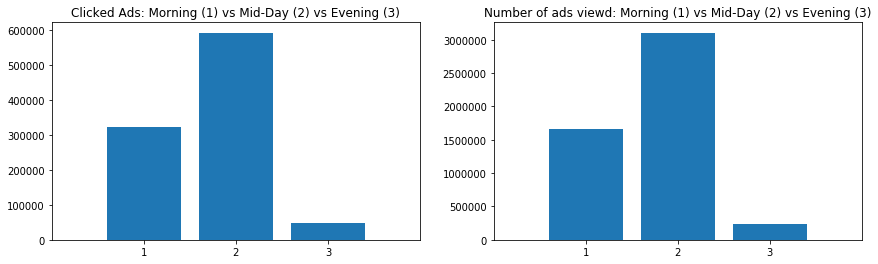

In [17]:
# number of clicks in different Time_of_day
fig, (ax1, ax2) = plt.subplots(1,2) 
fig.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=None, hspace=None)
ax1.bar([0,1,2,3], np.bincount(data['Time_of_day'][data.clicked==1]), width=0.8, align='center')
ax1.set_title('Clicked Ads: Morning (1) vs Mid-Day (2) vs Evening (3)')
ax1.set(xticks=range(1,4), xlim=[0, 4]);

# number of ad views in different Time_of day
ax2.bar([0,1,2,3], np.bincount(data['Time_of_day']), width=0.8, align='center')
ax2.set_title('Number of ads viewd: Morning (1) vs Mid-Day (2) vs Evening (3)')
ax2.set(xticks=range(1,4), xlim=[0, 4]);

### platform

In [18]:
data.platform.value_counts()

1     2141103
2     1693026
3      492518
1      307029
2      276299
3       90021
\N          4
Name: platform, dtype: int64

In [19]:
# Drop rows with '\N' values
data = data[data['platform'].isin([1,2,3,'1','2','3'])]
# Convert String Values to Integer
data = data.astype({'platform': 'int'})

In [20]:
data.platform.value_counts()

1    2448132
2    1969325
3     582539
Name: platform, dtype: int64

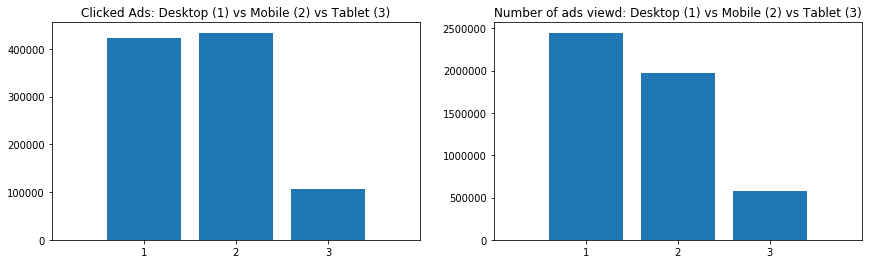

In [21]:
# number of clicks in different platform
fig, (ax1, ax2) = plt.subplots(1,2) 
fig.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=None, hspace=None)
ax1.bar([0,1,2,3], np.bincount(data['platform'][data.clicked==1]), width=0.8, align='center')
ax1.set_title('Clicked Ads: Desktop (1) vs Mobile (2) vs Tablet (3)')
ax1.set(xticks=range(1,4), xlim=[0, 4]);

# number of ad views in different platform
ax2.bar([0,1,2,3], np.bincount(data['platform']), width=0.8, align='center')
ax2.set_title('Number of ads viewd: Desktop (1) vs Mobile (2) vs Tablet (3)')
ax2.set(xticks=range(1,4), xlim=[0, 4]);

### Other Columns
- ad_id, campaign_id, advertiser_id, document_id

In [22]:
print('# unique: ',len(data.ad_id.unique()))
print('# unique: ',len(data.campaign_id.unique()))
print('# unique: ',len(data.advertiser_id.unique()))
print('# unique: ',len(data.document_id.unique()))

# unique:  97078
# unique:  18486
# unique:  2856
# unique:  121859


- Too many unique id's to form categorical features, can only leave it as integer values 
- Will perform feature scaling on these features

## Split Data and Train Model

In [23]:
data.head()

,display_id,ad_id,clicked,campaign_id,advertiser_id,document_id,platform,in_US,Time_of_day
0,1,42337,0,5969,1499,379743,3,1,3
1,1,139684,0,17527,2563,379743,3,1,3
2,1,144739,1,18488,2909,379743,3,1,3
3,1,156824,0,7283,1919,379743,3,1,3
4,1,279295,0,27524,1820,379743,3,1,3


In [24]:
# Split into predictors and target variable
X = data.drop(['display_id','clicked'],axis=1)
# Get dummy variables for categorical features of platform and time_of_day
X = pd.get_dummies(X,columns=['platform','Time_of_day'],drop_first=True)
y = data['clicked']

# Convert all X values to float 
X = X.astype('float')

## Scale Features

In [25]:
# Scale Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
# Split into train and validation set (Stratify)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, stratify=y)

## Cross-Valdiation + Model Selection + Parameter Tuning + Test Performance

### Logistic Regression

In [28]:
grid={"C":np.logspace(-3,3,7),"penalty":["l2"]}
logreg = LogisticRegression(solver='lbfgs')
logreg_cv = GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_scaled, y)
print(logreg_cv.best_params_)

{'C': 0.001, 'penalty': 'l2'}


In [29]:
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs',C=0.001,penalty='l2').fit(X_scaled, y)
acc_log = logreg.score(X_scaled, y)
print('Training Accuracy: ',acc_log)

# Cross Validation
cvs_log = np.mean(cross_val_score(logreg, X_scaled, y, cv=3))
print('Cross Validation Score: ',cvs_log)

# Test accuracy
logreg.fit(X_train, y_train)
pred_y_test = logreg.predict(X_test)
test_acc_log = accuracy_score(y_test,pred_y_test)
print('Test Accuracy: ', test_acc_log)

Training Accuracy:  0.8074002459201968
Cross Validation Score:  0.8074002459202614
Test Accuracy:  0.8074004893336298


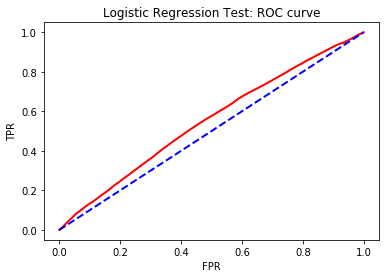

In [30]:
fpr, tpr,_=roc_curve(y_test,logreg.predict_proba(X_test)[:,1],drop_intermediate=False)
plt.figure()
####### Adding the ROC
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
####### Random FPR and TPR
plt.plot([0,1],[0,1], color='blue', lw=2, linestyle='--')
## Title and Label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Logistic Regression Test: ROC curve')
plt.show()

### Naive Bayes

In [31]:
# Naive Bayes
gaussian = GaussianNB().fit(X_scaled, y)
acc_gaussian = gaussian.score(X_scaled, y)
print('Training Accuracy: ',acc_gaussian)

# Cross Validataion
cvs_gaussian = np.mean(cross_val_score(gaussian, X_scaled, y, cv=3))
print("Cross Validation Score:", cvs_gaussian)

# Test accuracy
gaussian.fit(X_train, y_train)
pred_y_test = gaussian.predict(X_test)

test_acc_gaussian = accuracy_score(y_test,pred_y_test)
print("Test Accuracy: ",test_acc_gaussian)

Training Accuracy:  0.8074002459201968
Cross Validation Score: 0.7955124411651395
Test Accuracy:  0.8074004893336298


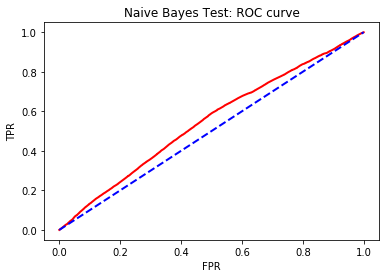

In [32]:
fpr, tpr,_=roc_curve(y_test,gaussian.predict_proba(X_test)[:,1],drop_intermediate=False)
plt.figure()
####### Adding the ROC
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
####### Random FPR and TPR
plt.plot([0,1],[0,1], color='blue', lw=2, linestyle='--')
## Title and Label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Naive Bayes Test: ROC curve')
plt.show()

### Random Forest Classifier

In [30]:
param_grid = [{'n_estimators':[5,15,30],'max_depth':[4,12,24]}]
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
grid.fit(X_scaled, y)
print(grid.best_params_)

{'max_depth': 12, 'n_estimators': 30}


In [34]:
# Run 2 #
param_grid = [{'n_estimators':[30,40,50],'max_depth':[9,12,15]}]
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
grid.fit(X_scaled, y)
print(grid.best_params_)

{'max_depth': 15, 'n_estimators': 50}


In [38]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=50,max_depth=15).fit(X_scaled, y)
acc_forest = random_forest.score(X_scaled, y)
print('Training Accuracy: ',acc_forest)

# Cross Validataion
cvs_forest = np.mean(cross_val_score(random_forest, X_scaled, y, cv=3))
print('Cross Validation Score: ',cvs_forest)

# Test accuracy
random_forest.fit(X_train, y_train)
pred_y_test = random_forest.predict(X_test)
test_acc_forest = accuracy_score(y_test,pred_y_test)
print('Test Accuracy: ', test_acc_forest)

Training Accuracy:  0.81246044996836
Cross Validation Score:  0.8097946481361035
Test Accuracy:  0.8111932189049812


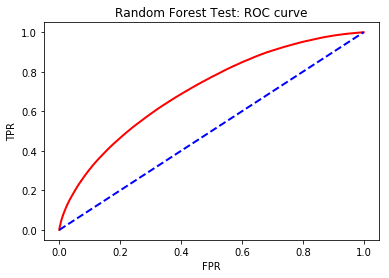

In [39]:
fpr, tpr,_=roc_curve(y_test,random_forest.predict_proba(X_test)[:,1],pos_label=1,drop_intermediate=False)
plt.figure()
####### Adding the ROC
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
####### Random FPR and TPR
plt.plot([0,1],[0,1], color='blue', lw=2, linestyle='--')
## Title and Label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Random Forest Test: ROC curve')
plt.show()

### Extreme Gradient Boosting (XGB Classifier)

In [32]:
param_grid = [{'n_estimators':[5,15,30],'max_depth':[4,12,24]}]
grid = GridSearchCV(XGBClassifier(), param_grid=param_grid, cv=5)
grid.fit(X_scaled, y)
print(grid.best_params_)

[06:12:03] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
{'max_depth': 12, 'n_estimators': 30}


In [33]:
# Run 2 #
param_grid = [{'n_estimators':[30,40,50],'max_depth':[9,12,15]}]
grid = GridSearchCV(XGBClassifier(), param_grid=param_grid, cv=5)
grid.fit(X_scaled, y)
print(grid.best_params_)

[10:36:49] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
{'max_depth': 15, 'n_estimators': 50}


In [35]:
# XGB Classifier
xgboost = XGBClassifier(n_estimators = 50,max_depth=15).fit(X_scaled, y)
acc_xgboost = xgboost.score(X_scaled, y)
print('Training Accuracy: ',acc_xgboost)

# Cross Validataion
cvs_xgboost = np.mean(cross_val_score(xgboost, X_scaled, y, cv=3))
print('Cross Validation Score: ',cvs_xgboost)

# Test accuracy
xgboost.fit(X_train, y_train)
pred_y_test = xgboost.predict(X_test)
test_acc_xgboost = accuracy_score(y_test,pred_y_test)
print('Test Accuracy: ', test_acc_xgboost)

[15:01:27] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Training Accuracy:  0.8169684535747629
Cross Validation Score:  0.8106636494221049
Test Accuracy:  0.8141707964671494


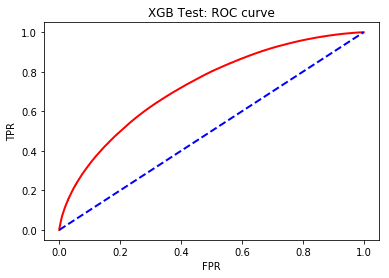

In [37]:
fpr, tpr,_=roc_curve(y_test,xgboost.predict_proba(X_test)[:,1],pos_label=1,drop_intermediate=False)
plt.figure()
####### Adding the ROC
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
####### Random FPR and TPR
plt.plot([0,1],[0,1], color='blue', lw=2, linestyle='--')
## Title and Label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('XGB Test: ROC curve')
plt.show()

### Results

In [35]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 
              'Naive Bayes',
              'Random Forest', 
              'XGBoosting'],
    'Train_Score': [acc_log, acc_gaussian, acc_forest, acc_xgboost],
    'Test_Score': [test_acc_log, test_acc_gaussian,test_acc_forest, test_acc_xgboost],
    'Cross_Validation':[cvs_log, cvs_gaussian,cvs_forest, cvs_xgboost]})
models

,Model,Train_Score,Test_Score,Cross_Validation
0,Logistic Regression,0.807400,0.807400,0.807400
1,Naive Bayes,0.807400,0.807400,0.795512
2,Random Forest,0.812460,0.811193,0.809795
3,XGBoosting,0.816968,0.814171,0.810664


- Best model is XGB Classifier
- Will use XGB Classifier with (n_estimators = 50, max_depth=15)

## Use all data to train model

In [45]:
model = XGBClassifier(n_estimators=50,max_depth=15).fit(X_scaled,y);

[16:34:54] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [46]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100},
                         index = X.columns)
Importance

,Importance
ad_id,9.400756
campaign_id,11.385811
advertiser_id,17.250858
document_id,2.963976
in_US,10.751355
platform_2,42.630836
platform_3,1.956905
Time_of_day_2,1.912577
Time_of_day_3,1.746930


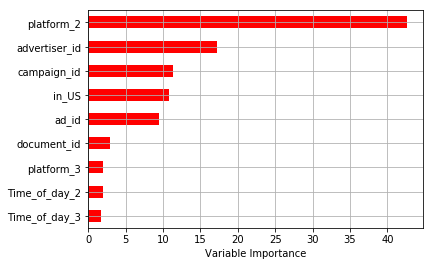

In [47]:
Importance.sort_values(by = 'Importance',axis = 0,ascending = True)\
                      .plot(kind = 'barh',color='r',)
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.grid()

## Feature Selection
- Remove bottom 4 features with low importance score and re-train model

In [48]:
X = X.drop(['Time_of_day_3','Time_of_day_2','platform_3','document_id'],axis=1)
X.head()

,ad_id,campaign_id,advertiser_id,in_US,platform_2
0,42337.0,5969.0,1499.0,1.0,0.0
1,139684.0,17527.0,2563.0,1.0,0.0
2,144739.0,18488.0,2909.0,1.0,0.0
3,156824.0,7283.0,1919.0,1.0,0.0
4,279295.0,27524.0,1820.0,1.0,0.0


In [49]:
# Scale Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [50]:
model = XGBClassifier(n_estimators=50,max_depth=15).fit(X_scaled,y);

[16:54:47] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [51]:
print('Training Score: ',model.score(X_scaled,y))

Training Score:  0.8113938491150793


### Prepare Test Dataset for Prediction

In [52]:
test= pd.read_csv('clicks_test.csv')
test.head()

,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754
3,16874594,170392
4,16874594,172888


### Merge files into one dataframe

In [53]:
# Merge train data + content on ad_id to get features about the ad
data_test = pd.merge(test,content,how='left',on='ad_id')
data_test.head()

# Load Full events.csv
events = pd.read_csv('events.csv')
# Merge train data + events on ad_id to get features about the ad 
data_test = pd.merge(data_test,events,how='left',on='display_id')
# Drop uuid (user id) as it is not a relevant feature
data_test = data_test.drop('uuid',axis=1)
data_test.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,display_id,ad_id,campaign_id,advertiser_id,document_id,timestamp,platform,geo_location
0,16874594,66758,8949,555,1792425,1026,3,US>MI>505
1,16874594,150083,19045,1913,1792425,1026,3,US>MI>505
2,16874594,162754,17770,2391,1792425,1026,3,US>MI>505
3,16874594,170392,20943,1731,1792425,1026,3,US>MI>505
4,16874594,172888,1384,16,1792425,1026,3,US>MI>505


### NaN Values

In [54]:
# Number of NaN values in data
data_test.isna().sum()

display_id         0
ad_id              0
campaign_id        0
advertiser_id      0
document_id        0
timestamp          0
platform           0
geo_location     507
dtype: int64

In [55]:
# Fill NaN values with string to represent Not in_US 
data_test.geo_location = data_test.geo_location.fillna('CA')

### geo_location

In [56]:
# Split into categorical feature of in_US
# 0 for not in US and 1 for in US
arr = []
for i in data_test.geo_location:
    if i.find("US") == -1:
        # Not in US
        arr.append(0)
    else:
        # In US
        arr.append(1)
data_test['in_US'] = arr
data_test = data_test.drop('geo_location',axis=1)

In [57]:
data_test['in_US'].value_counts()

1    25561077
0     6664085
Name: in_US, dtype: int64

### timestamp

In [58]:
# Convert time into year month date time format
data_test.timestamp = data_test.timestamp+1465876799998
data_test.timestamp = pd.to_datetime(data_test.timestamp,unit='ms')

In [59]:
# Convert Timestamp into categorical feature of Time_of_day
# 1 = morning, 2 = Mid-day, 3 = Evening
arr = []
for i in data_test.timestamp:
    hour = i.hour
    if (4<hour<=12):
        # Morning
        arr.append(1)
    elif (12<hour<=20):
        # Mid-day
        arr.append(2)
    else:
        # Evening
        arr.append(3)
data_test['Time_of_day'] = arr
data_test = data_test.drop('timestamp',axis=1)

In [60]:
data_test['Time_of_day'].value_counts()

2    13699880
3    10926801
1     7598481
Name: Time_of_day, dtype: int64

### platform

In [61]:
# Platform already in integer values
data_test.platform.value_counts()

1    14078309
2    13628287
3     4518566
Name: platform, dtype: int64

In [62]:
data_test.head()

,display_id,ad_id,campaign_id,advertiser_id,document_id,platform,in_US,Time_of_day
0,16874594,66758,8949,555,1792425,3,1,3
1,16874594,150083,19045,1913,1792425,3,1,3
2,16874594,162754,17770,2391,1792425,3,1,3
3,16874594,170392,20943,1731,1792425,3,1,3
4,16874594,172888,1384,16,1792425,3,1,3


### Dummy variables

In [63]:
# Split into predictors variable
X_submission = data_test.drop(['display_id'],axis=1)
# Get dummy variables for categorical features of platform and time_of_day
X_submission = pd.get_dummies(X_submission,columns=['platform','Time_of_day'],drop_first=True)
X_submission.head()

,ad_id,campaign_id,advertiser_id,document_id,in_US,platform_2,platform_3,Time_of_day_2,Time_of_day_3
0,66758,8949,555,1792425,1,0,1,0,1
1,150083,19045,1913,1792425,1,0,1,0,1
2,162754,17770,2391,1792425,1,0,1,0,1
3,170392,20943,1731,1792425,1,0,1,0,1
4,172888,1384,16,1792425,1,0,1,0,1


In [64]:
# Drop Features that are not important
X_submission = X_submission.drop(['Time_of_day_3','Time_of_day_2','platform_3','document_id'],axis=1)
X_submission.head()

,ad_id,campaign_id,advertiser_id,in_US,platform_2
0,66758,8949,555,1,0
1,150083,19045,1913,1,0
2,162754,17770,2391,1,0
3,170392,20943,1731,1,0
4,172888,1384,16,1,0


### Feature Scaling

In [65]:
# Scaled X_submission
Xsubmission_scaled = scaler.transform(X_submission)

In [66]:
# Predict Probability of Ad Clicks
pred=list(model.predict_proba(Xsubmission_scaled).astype(float)[:,1])

In [67]:
# Combine Test data with predicted probability
results=pd.concat((test,pd.DataFrame(pred)) ,axis=1,ignore_index=True)
results.head()

,0,1,2
0,16874594,66758,0.105589
1,16874594,150083,0.061631
2,16874594,162754,0.235533
3,16874594,170392,0.390913
4,16874594,172888,0.312130


In [68]:
# Rename the columns
results.columns = ['display_id','ad_id','clicked']
# Sort by Display ID and Highest Probability Clicked Ad
results = results.sort_values(by=['display_id','clicked'], ascending=[True, False])
results.head()

,display_id,ad_id,clicked
3,16874594,170392,0.390913
4,16874594,172888,0.312130
2,16874594,162754,0.235533
0,16874594,66758,0.105589
1,16874594,150083,0.061631


In [69]:
# Group by Display_id
results = results.reset_index(drop=True)
results=results[['display_id','ad_id']].groupby('display_id')['ad_id'].agg(lambda col: ' '.join(map(str,col)))
results.columns=[['display_id','ad_id']]
results.head()

display_id
16874594             170392 172888 162754 66758 150083 180797
16874595                                    8846 143982 30609
16874596    132820 11430 289122 289915 153260 57197 173005...
16874597    305790 308836 180965 155945 143981 285834 1820...
16874598                           145937 335632 67292 250082
Name: ad_id, dtype: object

In [70]:
# Put it back into dataframe to export to csv
result_df = pd.DataFrame(results).reset_index()
result_df.head()

,display_id,ad_id
0,16874594,170392 172888 162754 66758 150083 180797
1,16874595,8846 143982 30609
2,16874596,132820 11430 289122 289915 153260 57197 173005...
3,16874597,305790 308836 180965 155945 143981 285834 1820...
4,16874598,145937 335632 67292 250082


In [71]:
# Export to csv for submission to Kaggle
result_df.to_csv('submission_2.0.csv',index=False)